### 0. Используемые библиотеки и функции

In [1]:
######## MAIN
import pandas as pd
import json
import random
import time
import numpy as np
import sklearn as sk
import nltk
import matplotlib.pyplot as plt
from typing import List, Tuple

######## METRICS
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

######## LEARN
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


# функция чтения записей из файла
def read_file(path, i):      
    cl, p = path[i]
    
    rdata = pd.read_json(p, lines=True)
    row = pd.DataFrame({'class': [cl for j in range(len(rdata))]})   # создать столбец CLASS
    data = pd.concat([rdata, row], axis=1)                           # вставить столбец CLASS
    
    col = ['reviewText','class']
    return data[col]

# функция, формирующая полный датасет
def get_data(path):        
    data = pd.DataFrame()
    
    for i in range(len(path)):
        d0 = read_file(path,i)
        data = data.append(d0)
    
    return data

# вычисление AUC_ROC_SCORE для многоклассового случая
def multiclass_roc_auc_score(y_test, y_pred):
    lb = sk.preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred)



## Введите необходимые данные

In [2]:
# название групп и путь к файлам

path = np.array(['baby','data/reviews_Baby_5.json',  
                 'beauty','data/reviews_Beauty_5.json',
                'health','data/reviews_Health_and_Personal_Care_5.json']).reshape(-1,2)

# DATA FROM http://jmcauley.ucsd.edu/data/amazon/
# 5-star rattings groups: Beauty, Baby, Health and Personal Care
# I can't upload this files on GitHub, bcoz they're bigger than 25 MB


# кол-во записей каждой из групп товаров

N_1 = 10000    # кол-во записей 1-й группы
N_2 = 10000    # кол-во записей 2-й группы
N_3 = 10000    # кол-во записей 3-й группы


# параметры для моделей
C_ = 1         # параметр для SVM
N_ = 200       # параметр для RF
I_ = 250       # параметр для Gboost

### 1. Предобработка

In [3]:
full = get_data(path)         # получить датасет
full_prep = full.copy()
full_prep['class'].replace({path[0][0]: 1, path[1][0]: 2, path[2][0]: 3}, inplace=True)    # заменить метки классов на числа
full_prep.head()

full_prep_1 = full_prep[full_prep['class'] == 1][:N_1]     # взять N_1 записей из первой группы
full_prep_2 = full_prep[full_prep['class'] == 2][:N_2]     # взять N_2 записей из второй группы
full_prep_3 = full_prep[full_prep['class'] == 3][:N_3]     # взять N_3 записей из третей группы
full_prep = pd.DataFrame()
full_prep = full_prep.append(full_prep_1).append(full_prep_2).append(full_prep_3)


# предобработка. Выделение данных и целевой переменной
full2 = shuffle(full_prep, random_state=241)
data = full2['reviewText']
target = full2['class']

# предобработка. разбиение на ОБУЧЕНИЕ и ТЕСТ
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

X_train = X_train.values.astype('U')
X_test = X_test.values.astype('U')
y_train = y_train.values.astype('U')
y_test = y_test.values.astype('U')

# предобработка. Векторизация признаков
text = TfidfVectorizer(min_df=10, decode_error='replace', encoding='utf-8', stop_words='english')
X = text.fit_transform(X_train)




### 2.1 SVM (Метод опорных векторов)

In [4]:
acc = []
f2_score = []
ROC = []


clf = SVC(C = C_, random_state=241, kernel='linear', decision_function_shape='ovo')        # классификатор
clf.fit(X, y_train)
svm_preds = clf.predict(text.transform(X_test))

acc = acc + [accuracy_score(y_test, svm_preds)]
f2_score = f2_score + [f1_score(y_test, svm_preds, average = 'macro')]
ROC = ROC + [multiclass_roc_auc_score(y_test, svm_preds)]

In [5]:
# Результаты для построения облаков слов

feature_names = np.array(text.get_feature_names())
sorted_tfidf_index = X.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

sorted_coef_index = clf.coef_[0].toarray()[0].argsort()
print('\nSmallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest tfidf:
['summary' 'intuitive' 'route' 'edta' '210' 'explode' 'blotchy'
 'preservatives' '95' 'rebecca']

Largest tfidf: 
['nice' 'know' 'better' 'works' 'delicious' 'ok' 'love' 'refreshing'
 'good' 'gift']

Smallest Coefs:
['hair' 'skin' 'face' 'smells' 'scent' 'brush' 'fragrance' 'lotion' 'oil'
 'soap']

Largest Coefs: 
['baby' 'son' 'diaper' 'daughter' 'nipples' 'milk' 'bottles' 'avent'
 'crib' 'pillow']


### 2.2 RF (Случайный лес)

In [6]:
n = 260
forest = RandomForestClassifier(n_estimators=N_, random_state=241, n_jobs=-1) # n_jobs=-1 - parallel on all processors
forest.fit(X, y_train)
rf_preds = forest.predict(text.transform(X_test))

acc = acc + [accuracy_score(y_test, rf_preds)]
f2_score = f2_score + [f1_score(y_test, rf_preds, average = 'macro')]
ROC = ROC + [multiclass_roc_auc_score(y_test, rf_preds)]

### 2.3 Gboost (Градиентный бустинг)

In [7]:
gb = GradientBoostingClassifier(learning_rate=1, n_estimators=I_, random_state=241)
gb.fit(X, y_train)
gb_preds = gb.predict(text.transform(X_test))


acc = acc + [accuracy_score(y_test, gb_preds)]
f2_score = f2_score + [f1_score(y_test, gb_preds, average = 'macro')]
ROC = ROC + [multiclass_roc_auc_score(y_test, gb_preds)]

### 3. Сравнение результатов по трем методам

/Users/satankov/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


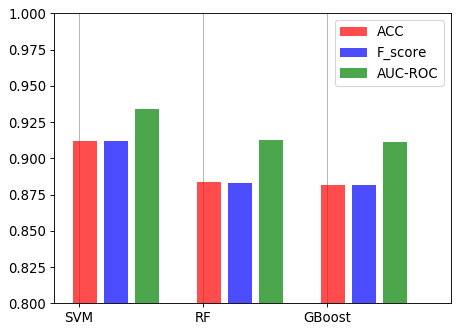

In [8]:
import matplotlib as mpl
import matplotlib.dates as mdates
import datetime as dt
import csv

data_names = ['SVM', 'RF', 'GBoost']

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 12})

plt.title('')

ax = plt.axes()
ax.xaxis.grid(True, zorder = 1)

xs = range(len(data_names))

plt.bar([x + 0.05 for x in xs], acc,
        width = 0.2, color = 'red', alpha = 0.7, label = 'ACC',
        zorder = 2)
plt.bar([x + 0.3 for x in xs], f2_score,
        width = 0.2, color = 'blue', alpha = 0.7, label = 'F_score',
        zorder = 2)
plt.bar([x + 0.55 for x in xs], ROC,
        width = 0.2, color = 'green', alpha = 0.7, label = 'AUC-ROC',
        zorder = 2)

plt.axis([-.2, 3, 0.8, 1])
plt.xticks(xs, data_names, rotation = 0)

plt.legend(loc='best')


# 4. ПОДБОР оптимальных параметров для трех методов

### 4.1 Подбор значения параметра 'C'  для метода SVM

In [7]:
start_time = time.time()

svm_scores = pd.DataFrame(columns=['c','acc','f_macro','roc'])


range_ = np.power(10.0, np.arange(-3, 4))
for c in range_:
    clf = SVC(C = c, random_state=241, kernel='linear', decision_function_shape='ovo')        # классификатор
    clf.fit(X, y_train)
    svm_preds = clf.predict(text.transform(X_test))
    
    roc = multiclass_roc_auc_score(y_test, svm_preds)
    acc = accuracy_score(y_test, svm_preds)
    f_macro = f1_score(y_test, svm_preds, average = 'macro')
    
    svm_scores = svm_scores.append({'c': c, 'acc': acc, 'f_macro': f_macro, 'roc': roc}, 
                                   ignore_index=True)

print("\n--- %s seconds ---" % (time.time() - start_time))

/Users/satankov/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



--- 5221.950565099716 seconds ---


In [ ]:
# Export results

svm_scores.to_csv('result/svm_150k.csv')     # find C
svm_scores

### 4.2 Подбор значения параметра 'n'  для метода RF

In [8]:
start_time = time.time()

rf_scores = pd.DataFrame(columns=['n','acc','f_macro','roc'])

X_test_t = text.transform(X_test)
for n in range(10, 510, 50):
    forest = RandomForestClassifier(n_estimators=n, random_state=241, n_jobs=-1) # n_jobs=-1 - parallel on all processors
    forest.fit(X, y_train)
    rf_preds = forest.predict(X_test_t)
    
    roc = multiclass_roc_auc_score(y_test, rf_preds)
    acc = accuracy_score(y_test, rf_preds)
    f_macro = f1_score(y_test, rf_preds, average = 'macro')
    
    rf_scores = rf_scores.append({'n': n, 'acc': acc, 'f_macro': f_macro, 'roc': roc}, ignore_index=True)

print("\n--- %s seconds ---" % (time.time() - start_time))


--- 5149.464565038681 seconds ---


In [9]:
rf_scores.to_csv('result/rf_150k.csv')
rf_scores

### 4.3 Подбор значения параметра 'n'  для метода Gboost

In [62]:
def sigmoid(y_pred: np.array) -> np.array:
    return 1.0 / (1.0 + np.exp(-y_pred))

def log_loss_results(model, X: np.array, y: np.array) -> List[float]:
    return [log_loss(y, sigmoid(y_pred)) for y_pred in model.staged_decision_function(X)]

Learning rate: 1.0
      Iter       Train Loss   Remaining Time 
         1        2647.1491            7.53s
         2        2338.2032            7.38s
         3        2099.2049            7.39s
         4        1940.9199            7.53s
         5        1832.0805            7.35s
         6        1732.1680            7.23s
         7        1647.0582            7.21s
         8        1567.8759            7.48s
         9        1503.1692            7.60s
        10        1446.8504            7.57s
        20        1016.0422            6.54s
        30         759.4118            5.56s
        40         578.1912            4.64s
        50         470.1194            3.83s
        60         385.5672            3.07s
        70         320.8683            2.28s
        80         268.2682            1.51s
        90         233.7997            0.76s
       100         203.6153            0.00s


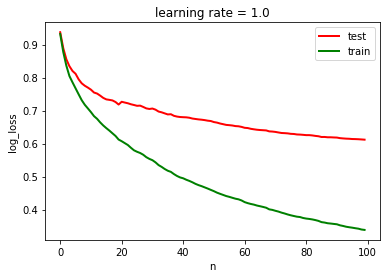

Min loss 0.61 at n_estimators=100

Learning rate: 0.5
      Iter       Train Loss   Remaining Time 
         1        3013.2216            8.05s
         2        2699.6796            7.61s
         3        2495.2751            7.49s
         4        2351.6429            7.33s
         5        2234.1863            7.19s
         6        2145.5489            7.10s
         7        2060.8273            7.00s
         8        1989.1825            6.89s
         9        1923.6079            6.84s
        10        1864.5866            6.81s
        20        1456.6593            6.31s
        30        1229.0838            5.58s
        40        1045.3916            4.69s
        50         916.9815            3.89s
        60         812.2533            3.12s
        70         721.6089            2.35s
        80         654.6269            1.55s
        90         597.7762            0.77s
       100         547.8223            0.00s


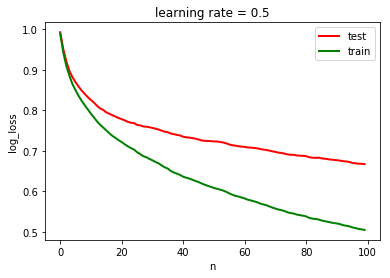

Min loss 0.67 at n_estimators=100

Learning rate: 0.25
      Iter       Train Loss   Remaining Time 
         1        3320.9049            7.95s
         2        3058.8977            7.63s
         3        2876.6478            7.49s
         4        2736.6618            7.48s
         5        2622.1898            7.45s
         6        2531.1322            7.41s
         7        2449.2022            7.36s
         8        2380.8405            7.21s
         9        2320.1164            7.13s
        10        2264.8398            7.19s
        20        1887.4167            6.58s
        30        1663.3757            5.70s
        40        1506.7382            4.84s
        50        1374.6587            4.02s
        60        1268.0304            3.21s
        70        1176.2314            2.38s
        80        1095.8641            1.59s
        90        1033.4201            0.79s
       100         968.4456            0.00s


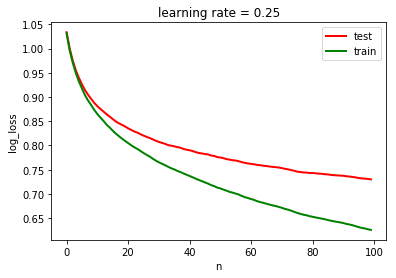

Min loss 0.73 at n_estimators=100

Learning rate: 0.1
      Iter       Train Loss   Remaining Time 
         1        3561.6336            8.67s
         2        3409.2934            7.90s
         3        3282.7612            7.71s
         4        3175.9548            7.57s
         5        3082.5525            7.42s
         6        3001.5146            7.34s
         7        2931.0660            7.50s
         8        2868.0859            7.64s
         9        2809.4153            7.52s
        10        2757.6459            7.55s
        20        2401.8440            6.86s
        30        2190.7351            5.93s
        40        2032.9368            5.11s
        50        1909.6475            4.24s
        60        1810.7833            3.39s
        70        1729.3953            2.58s
        80        1652.6708            1.71s
        90        1585.7879            0.85s
       100        1529.1247            0.00s


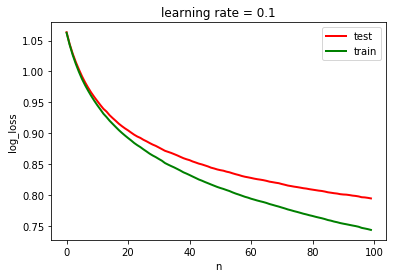

Min loss 0.79 at n_estimators=100



In [79]:
def plot_loss(learning_rate: float, test_loss: List[float], train_loss: List[float]) -> None:
    plt.figure()
    plt.plot(test_loss, "r", linewidth=2)
    plt.plot(train_loss, "g", linewidth=2)
    plt.legend(["test", "train"])
    plt.xlabel('n')
    plt.ylabel('log_loss')
    plt.title('learning rate = ' + str(learning_rate) + '')
    plt.show()

min_loss_results = {}
X_test_t = text.transform(X_test)
range_lr = np.array([1, 0.5, 0.25, 0.1])
for lr in range_lr:
    print(f"Learning rate: {lr}")

    model = GradientBoostingClassifier(learning_rate=lr, n_estimators=100, verbose=True, random_state=241
                                        #, validation_fraction=0.2, n_iter_no_change=100, tol=0.01
                                      )
    model.fit(X, y_train)
    
    train_loss = log_loss_results(model, X, y_train)
    test_loss = log_loss_results(model, X_test_t, y_test)
    plot_loss(lr, test_loss, train_loss)
    
    min_loss_value = min(test_loss)
    min_loss_index = test_loss.index(min_loss_value) + 1
    min_loss_results[lr] = min_loss_value, min_loss_index

    print(f"Min loss {min_loss_value:.2f} at n_estimators={min_loss_index}\n")

In [142]:
min_loss_value, min_loss_index = min_loss_results[1]
print(f"{min_loss_value:.2f} {min_loss_index}")

0.98 11
